<a href="https://colab.research.google.com/github/sambhajizambre/Project/blob/main/NLP_Sentiment_Analysis_Tweeter_Data3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

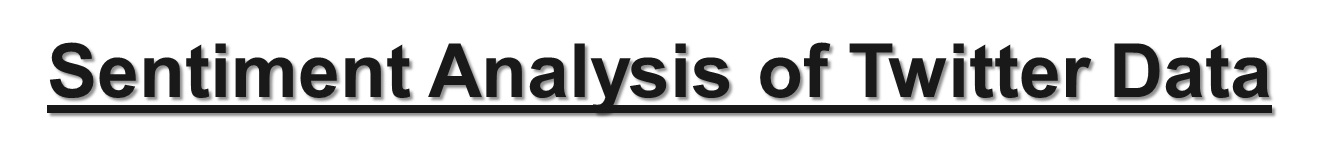

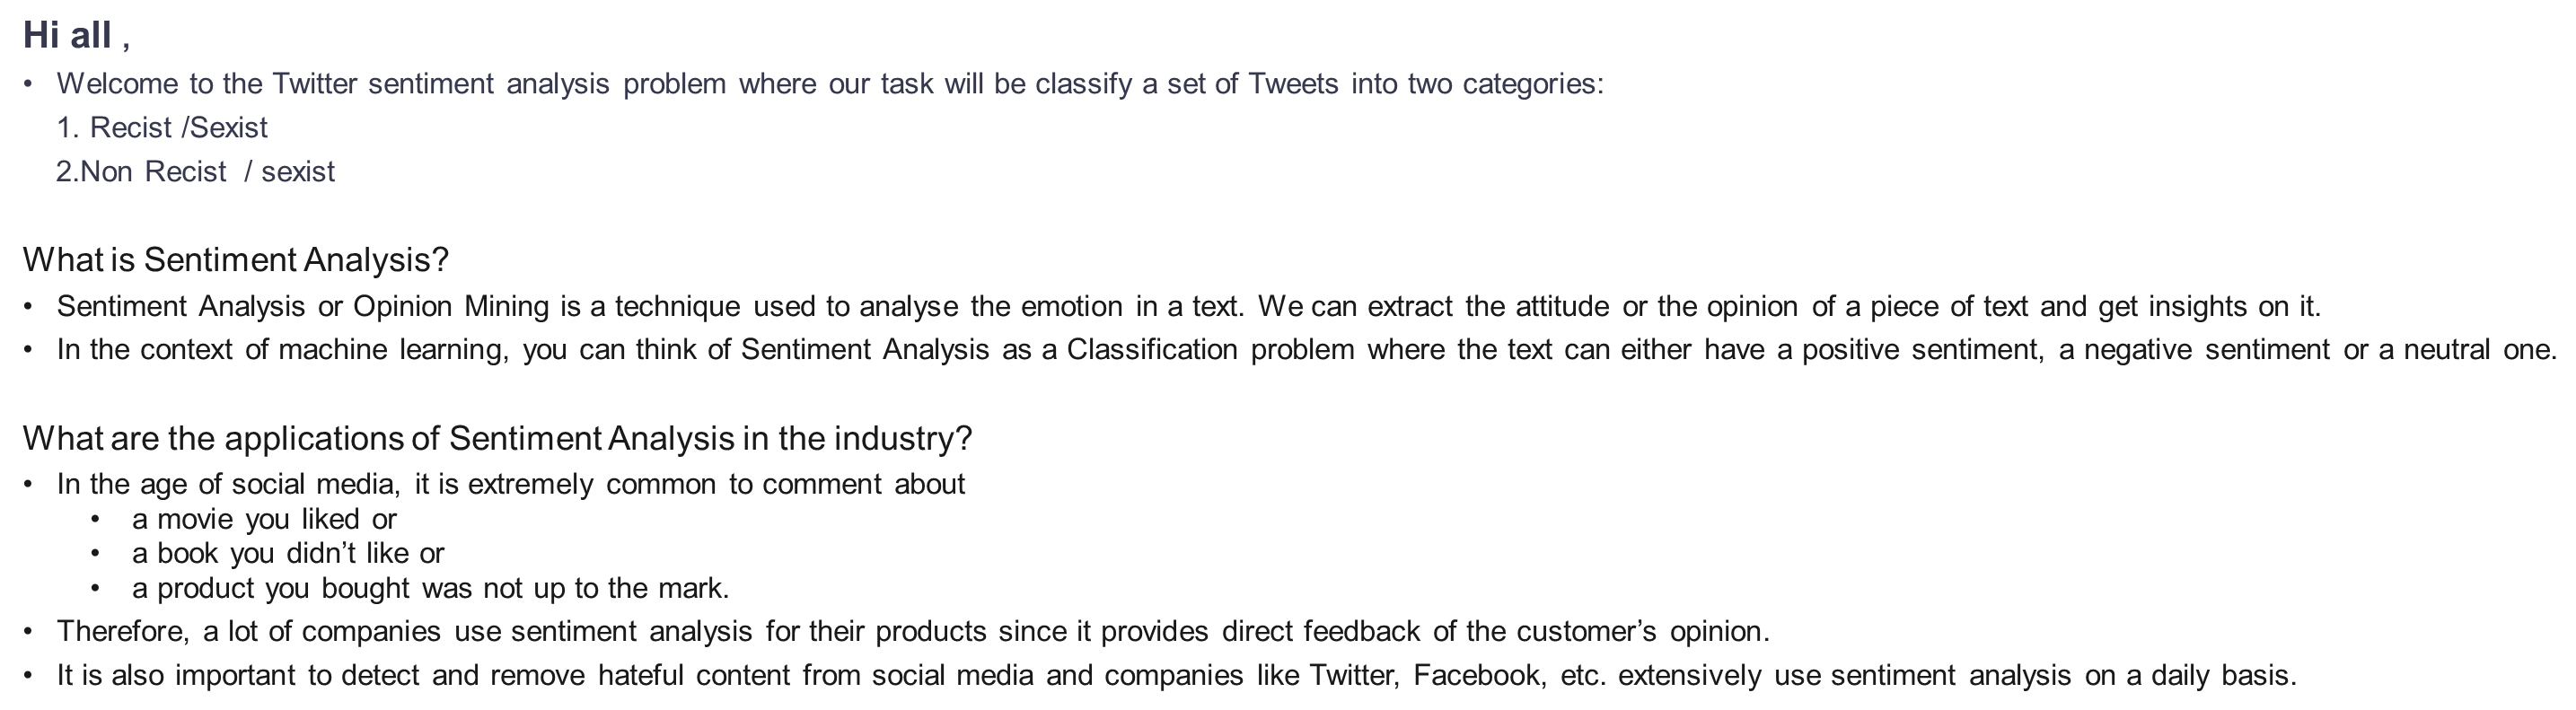

## Objective 

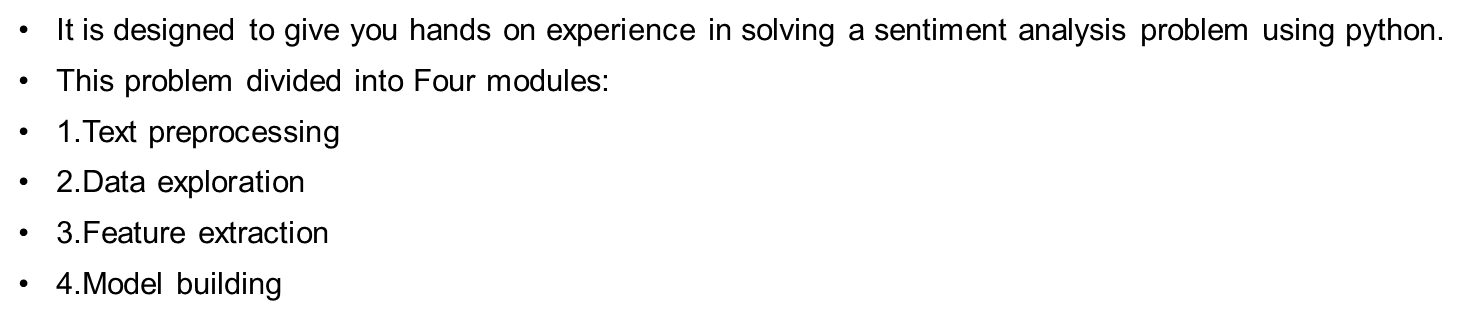

# Motivation 
Hate speech is an unfortunately common occurrence on the Internet. Often social media sites like Facebook and Twitter face the problem of identifying and censoring problematic posts while weighing the right to freedom of speech. The importance of detecting and moderating hate speech is evident from the strong connection between hate speech and actual hate crimes. Early identification of users promoting hate speech could enable outreach programs that attempt to prevent an escalation from speech to action. Sites such as Twitter and Facebook have been seeking to actively combat hate speech. In spite of these reasons, NLP research on hate speech has been very limited, primarily due to the lack of a general definition of hate speech, an analysis of its demographic influences, and an investigation of the most effective features.

##Table of Contents
####Problem Statement: Twitter Sentiment Analysis
####Import Data     
####Data Cleaning     
-Removing Twitter Handles(@user)    
-Removing Punctuations, Numbers, spacial Characters and Stop Words  
-Removing short Words   
-Spelling Correction   
-Text Normalization   
####Visualization from Tweets  
A) Understanding the common words used in the tweets: WordCloud  

B) Words in non racist/sexist tweets   

C) Racist/Sexist Tweets  

D) Understanding the impact of Hashtags on tweets sentiment   

#### Feature Extraction       
-Bag-of-Words Features     
-TF-IDF Features    
-Word2Vec Features   
-Word2Vec Embeddings   
-Preparing Vectors for Tweets  
-Doc2Vec Embedding   
-Preparing doc2vec Feature Set
#### Model Building
-Logistic Regression
-Support Vector Machine(SVM)    
-Random Forest     
-XGBoost

#### Fine Tuning XGBoost+Word2Vec
-Tuning max_depth and min_child_weight     
-Tuning subsample and colsample     
-Tuning the learning rate.    
-Final list of tuned parameters.

#### final predicion file.
### Summary

#Problem Statement:

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiments associalted with it. so the task is to classify racist or sexist tweets from the other tweets.


Formally, given a training sample of tweets and label, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import warnings
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
df_train=pd.read_csv('/content/drive/MyDrive/python/Train_tweets.csv')
df_test=pd.read_csv('/content/drive/MyDrive/python/Test_tweets.csv')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_train.shape

(31962, 3)

In [5]:
df_train.columns

Index(['id', 'label', 'tweet'], dtype='object')

In [6]:
df_test.shape

(17197, 2)

In [7]:
df_test.columns

Index(['id', 'tweet'], dtype='object')

In [8]:
df_train.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [9]:
df_test.isna().sum()

id       0
tweet    0
dtype: int64

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [11]:
df_train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [12]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [13]:
df_train['label'].unique()

array([0, 1])

Now we will check out some non racist/sexist tweets : 

In [14]:
df_train[df_train['label']==0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


Now we will check out some racist/sexist tweets :

In [15]:
df_train[df_train['label']==1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


Now we can see there are many words and characters which are not required in the tweets for our analysis.

Lets check label distribution in the dataset:

In [16]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

So we can see there are 29720 tweets are non racist/sexist and only 2242 tweets are racist/sexist tweets.

Checking length disrtibution of words in the tweets in both train and test data:

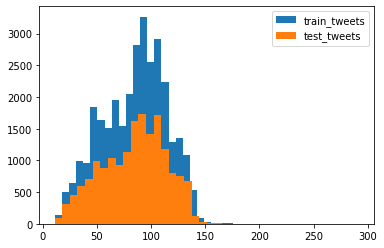

In [17]:
length_train=df_train['tweet'].str.len()
length_test=df_test['tweet'].str.len()
plt.hist(length_train, bins=40, label="train_tweets")
plt.hist(length_test, bins=40, label="test_tweets")
plt.legend()
plt.show()

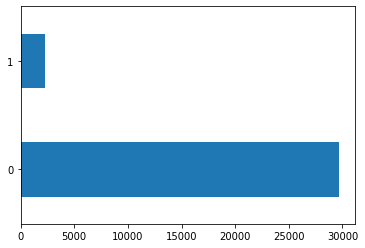

In [19]:
df_train['label'].value_counts()[:20].plot(kind='barh')

#Data Cleaning

Before we begin cleaning, let's first combine train and test datasets. Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.

In [21]:
df = df_train.append(df_test, ignore_index=True, sort=False)
df.shape

(49159, 3)

Given below is a user-defined function to remove unwanted text patterns from tweets.

In [22]:
df.isna().sum()

id           0
label    17197
tweet        0
dtype: int64

In [23]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

**1. Removing Twitter Handles (@user)**

In [24]:
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")
df.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


**2. Removing Punctuations, Numbers, and Special Characters**

Here we will replace everything except characters and hashtags with spaces. The regular expression "[^a-zA-Z#]" means anything except alphabets and '#'

In [25]:
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") 
df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here i m it s so #gr


**3.Removing Short Words**

We have to be a little careful here in selecting the length of the words which we want to remove . So , I have decided to remove all the words having length 3 or less . For example , terms like " hmm " , " oh " are of very little use . It is better to get rid of them .

In [26]:
df['tidy_tweet'] =df['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3])) 
df

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #tru...,thought factory left right polarisation #trump...
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverre...,feeling like mermaid #hairflip #neverready #fo...
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...,#hillary #campaigned today #ohio used words li...
49157,49158,NaN,"happy, at work conference: right mindset leads...",happy work conference right mindset leads cult...


We can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

**4. Text Normalization**

Here we will use nltk's PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [27]:
tokenized_tweet =df['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

Now we can normalize the tokenized tweets:

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x:[stemmer.stem(i) for i in x])  #  stemming

Now let's stitch these tokens back together. It can easily be done using nltk's MosesDetokenizer function:

In [28]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i]  = ' '.join(tokenized_tweet[i])

df['tidy_tweet'] = tokenized_tweet    
df.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


#Visualization from Tweets:

**A) Understanding the common words used in the tweets: WordCloud**

In [29]:
all_words = ' '.join([text for text in df['tidy_tweet']]) 

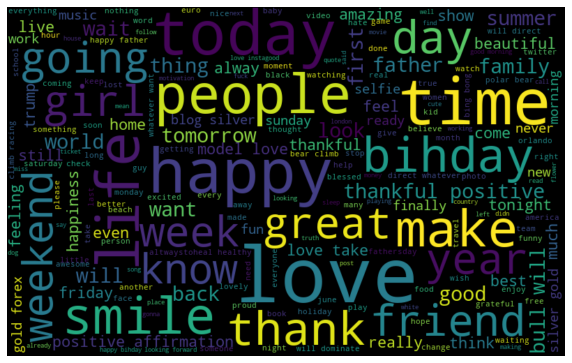

In [30]:
 from wordcloud import WordCloud
 wordcloud = WordCloud(width=800, height=500, random_state=21,
                      max_font_size=110).generate(all_words)
 plt.figure(figsize=(10,7))
 plt.imshow(wordcloud,interpolation="bilinear") 
 plt.axis('off')
 plt.show()                                                     

We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn't give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

**B) Words in non racist/sexist tweets**

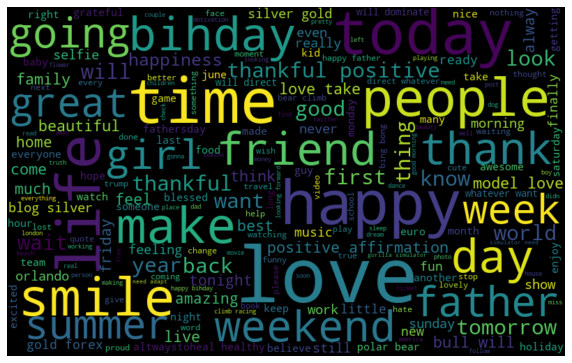

In [31]:
normal_words = ' '.join([text for text in df['tidy_tweet'] [df['label'] == 0]])

wordcloud = WordCloud (width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt .axis('off')
plt.show()


Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

**C) Racist/Sexist Tweets:**

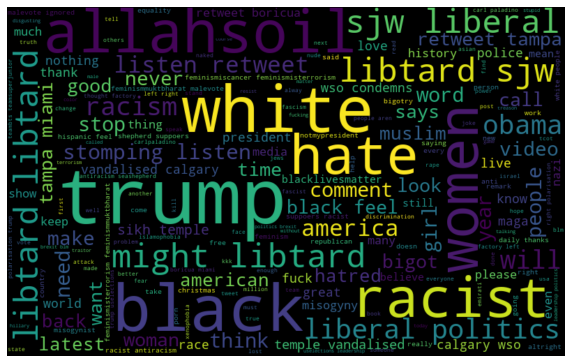

In [32]:
negative_words = ' ' .join([text for text in df['tidy_tweet'] [df['label'] == 1]]) 
wordcloud = WordCloud (width=800, height=500, random_state=21, max_font_size=110).generate ( negative_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

**D) Understanding the impact of Hashtags on tweets sentiment:**


Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

For instance, given below is a tweet from our dataset:

**"what has today's attitude to women got in common with that of norman bates? #psycho #feminism #hollaback"**

The tweet seems sexist in nature and the Hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists - one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [33]:
def hashtag_extract(x):
    hashtags = []   # Loop over the words in the tweet 
    for i in x:
       ht = re.findall(r"#(\w+)", i)
       hashtags.append(ht) 
    return hashtags

# extracting hashtags from noh racist/sexist tweets
HT_regular = hashtag_extract(df['tidy_tweet'][df['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative=hashtag_extract(df['tidy_tweet'][df['label'] == 1]) 
#unnesting list 
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

**Non Racist/sexist tweets:**

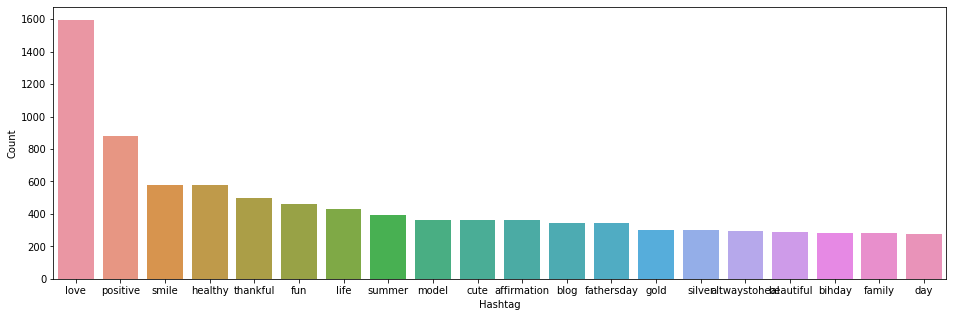

In [34]:
a = nltk.FreqDist (HT_regular) 
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})

 # selecting top 20 most frequent hashtags d

d=d.nlargest (columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y = "Count") 
ax. set(ylabel = 'Count') 
plt.show()

All the hashtags are positive and it make sense. I am expecting negative terms in the plots of the second list. Lets check the most frequent hastags appering  in the racist or sexist tweets:

**Racist/sexist tweets:**

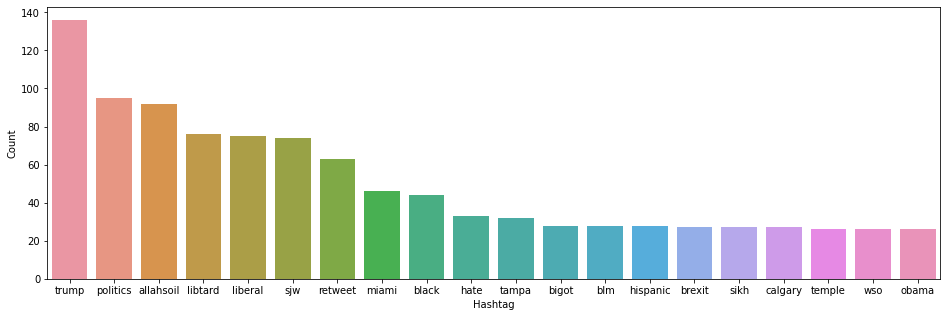

In [35]:
b=nltk.FreqDist(HT_negative)
e=pd.DataFrame({'Hashtag':list(b.keys()),'Count':list(b.values())})

e=e.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x="Hashtag", y = "Count") 
ax. set(ylabel = 'Count') 
plt.show()

As expected most of the terms are negative with a few neutral terms as well. So its nit a bad idea to keep these hashtags in our data as they contain useful information. 

Next we will try to extract features from the tokenized tweets.

#Feature extraction:
#Bag-of-Words Features    
To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag of Words, TF-IDF, and Word Embeddings.

In [36]:
#feature extraction:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizre = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizre.fit_transform(df['tidy_tweet'])
bow.shape

(49159, 1000)

In [37]:
bow[0].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [38]:
bow

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 163536 stored elements in Compressed Sparse Row format>

In [39]:
bow[0]

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

#TF-IDF Features  
This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
import gensim

In [41]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90 , min_df = 2, max_features=1000, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(df['tidy_tweet'])
tfidf.shape

(49159, 1000)

# Word2Vec Features
Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. They are able to achieve tasks like King -man +woman = Queen, which is mind-blowing.

The advantages of using word embeddings over BOW or TF-IDF are:

Dimensionality reduction - significant reduction in the no. of features required to build a model.

It capture meanings of the words, semantic relationships and the different types of contexts they are used in.

Let’s train a Word2Vec model on our corpus

In [42]:
tokenized_tweet = df['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200,                                        # desired no. of features/independent variables
            window=5,                                        # context window size
            min_count=2,
            sg = 1,                                          # 1 for skip-gram model
            hs = 0,
            negative = 10,                                   # for negative sampling
            workers= 2,                                      # no.of cores
            seed = 34) 

model_w2v.train(tokenized_tweet, total_examples= len(df['tidy_tweet']), epochs=20)

(6480169, 7536020)

Let’s play a bit with our Word2Vec model and see how does it perform. We will specify a word and the model will pull out the most similar words from the corpus.

In [43]:
model_w2v.wv.most_similar(positive="dinner")

[('lamb', 0.6105947494506836),
 ('burritos', 0.6011862754821777),
 ('spaghetti', 0.6000123023986816),
 ('noodle', 0.5838770270347595),
 ('gown', 0.5720425844192505),
 ('beers', 0.5673520565032959),
 ('#lovefood', 0.5653676986694336),
 ('melanie', 0.5633713006973267),
 ('kayaking', 0.5633413791656494),
 ('#toast', 0.5616310834884644)]

In [44]:
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.5932439565658569),
 ('unfavorability', 0.5606092214584351),
 ('commie', 0.5427486896514893),
 ('#delegaterevolt', 0.5341386795043945),
 ('phony', 0.5322540402412415),
 ('chopra', 0.5313804745674133),
 ('hillary', 0.5308897495269775),
 ('unstable', 0.5281373262405396),
 ('nominee', 0.5210703611373901),
 ('endorses', 0.5199201107025146)]

Let’s check the vector representation of any word from our corpus.

In [45]:
model_w2v['food']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.42329577, -0.7967403 ,  0.09126575,  0.0687596 ,  0.12751994,
        0.17264736, -0.6674562 , -0.37139946,  0.23961046,  0.31785575,
        0.5808414 , -0.79094493,  0.5968238 ,  0.00156337, -0.11097104,
       -0.35586902,  0.59927714,  0.15903512,  0.79259276,  0.12059997,
       -0.5312266 ,  0.50346535, -0.36805576, -0.28027415,  0.7867424 ,
        0.4401905 ,  0.22223432,  0.06883977,  0.374967  , -0.36198625,
        0.80742645, -0.27401337,  0.04675006,  0.55262166,  0.59769523,
        1.1059966 , -0.5690942 ,  0.8149199 ,  0.19091582, -0.31935   ,
        0.1290464 ,  0.7191235 ,  0.34342006, -0.48708808, -0.22130485,
        0.21930955,  0.20853397,  0.17264682, -0.12068815, -0.16186689,
       -0.8735672 , -0.73668575, -0.00717008,  0.02018345, -0.1792801 ,
        0.04374712, -0.02537377, -0.28768462, -0.45537114, -0.2429966 ,
        0.42878455,  0.42459467,  0.22253282,  0.0716612 , -0.80446815,
        0.32095504, -0.01827318, -0.14409581,  0.28165558, -0.46

In [46]:
len(model_w2v['food'])                               #The length of the vector is 200

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


200

#Preparing Vectors for Tweets
Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [47]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary                                     
          continue
    if count != 0:
        vec /= count
    return vec

In [48]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays) 

wordvec_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(49159, 200)

2. Doc2Vec Embedding    
Doc2Vec model is an unsupervised algorithm to generate vectors for sentence/paragraphs/documents. This approach is an extension of the word2vec. The major difference between the two is that doc2vec provides an additional context which is unique for every document in the corpus. This additional context is nothing but another feature vector for the whole document. This document vector is trained along with the word vectors.

In [49]:
# Let’s load the required libraries.
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence

To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [50]:
def add_label(twt):
  output = []
  for i, s in zip (twt.index , twt):
    output.append(LabeledSentence(s,["tweet_" + str(i)]))
  return output

labeled_tweets = add_label(tokenized_tweet)                       #label all tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.


In [51]:
labeled_tweets[:5]

[LabeledSentence(words=['when', 'father', 'dysfunctional', 'selfish', 'drags', 'kids', 'into', 'dysfunction', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thanks', '#lyft', 'credit', 'cause', 'they', 'offer', 'wheelchair', 'vans', '#disapointed', '#getthanked'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'love', 'take', 'with', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguide', 'society', '#motivation'], tags=['tweet_4'])]

Now let’s train a doc2vec model.

In [52]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model                                   
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors                                  
                                  size=200,                                                        # no. of desired features                                  
window=5,                                                                                          # width of the context window                                  
negative=7,                                                                                        # if > 0 then negative sampling will be used                                 
min_count=5,                                                                                       # Ignores all words with total frequency lower than 2.                                  
workers=3,                                                                                         # no. of cores                                  
alpha=0.1,                                                                                         # learning rate                                  
seed = 23) 
model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])
model_d2v.train(labeled_tweets, total_examples= len(df['tidy_tweet']), epochs=15)

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 49159/49159 [00:00<00:00, 1306474.40it/s]


#Preparing doc2vec Feature Set

In [53]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(df)):
  docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 200)

# Model Building

##Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix

#Bag-of-Words Features
We will first try to fit the logistic regression model on the Bag-of_Words (BoW) features.

In [55]:
# Extracting train and test BoW features 
train_bow = bow[:31962,:] 
test_bow = bow[31962:,:] 

# splitting data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df_train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


0.5017421602787456

In [56]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, df['label'], random_state = 42, test_size = 0.25)

# Now let’s make predictions for the test dataset and create a submission file.

In [57]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
df_test['label'] = test_pred_int
submission = df_test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


# TF-IDF Features

We’ll follow the same steps as above, but now for the TF-IDF feature set.

In [58]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:] 

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain) 

prediction = lreg.predict_proba(xvalid_tfidf)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int) 

f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


0.5091240875912408

#  Word2Vec Features

In [59]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

lreg.fit(xtrain_w2v, ytrain) 

prediction = lreg.predict_proba(xvalid_w2v)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


0.607275426874536

# Doc2Vec Features

In [60]:
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:] 

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

lreg.fit(xtrain_d2v, ytrain) 

prediction = lreg.predict_proba(xvalid_d2v)

prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


0.34844444444444445

# Support Vector Machine (SVM)

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However, it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes as shown in the plot below

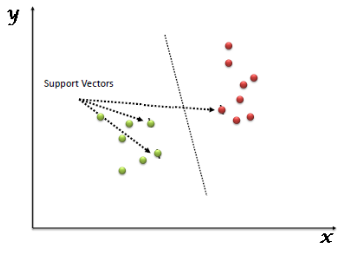

In [61]:
from sklearn import svm

# Bag-of-Words Features

In [62]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain) 
prediction = svc.predict_proba(xvalid_bow) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


0.49126034958601666

Again let’s make predictions for the test dataset and create another submission file.

In [63]:
test_pred = svc.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3 
test_pred_int = test_pred_int.astype(np.int) 
df_test['label'] = test_pred_int 
submission = df_test[['id','label']] 
submission.to_csv('sub_svm_bow.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


Here validation score is slightly lesser than the Logistic Regression score for bag-of-words features.

###TF-IDF Features

In [64]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


0.48044692737430167

### Word2Vec Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


0.6244131455399061

### Doc2Vec Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain) 
prediction = svc.predict_proba(xvalid_d2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


0.24061810154525387

### RandomForest

Random Forest is a versatile machine learning algorithm capable of performing both regression and classification tasks. It is a kind of ensemble learning method, where a few weak models combine to form a powerful model. In Random Forest, we grow multiple trees as opposed to a decision single tree. To classify a new object based on attributes, each tree gives a classification and we say the tree “votes” for that class. The forest chooses the classification having the most votes (over all the trees in the forest).

It works in the following manner. Each tree is planted & grown as follows:

Assume number of cases in the training set is N. Then, sample of these N cases is taken at random but with replacement. This sample will be the training set for growing the tree.

If there are M input variables, a number m (m<M) is specified such that at each node, m variables are selected at random out of the M. The best split on these m variables is used to split the node. The value of m is held constant while we grow the forest.

Each tree is grown to the largest extent possible and there is no pruning.

Predict new data by aggregating the predictions of the ntree trees (i.e., majority votes for classification, average for regression).

In [65]:
from sklearn.ensemble import RandomForestClassifier

### Bag-of-Words Features

In [66]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain) 
prediction = rf.predict(xvalid_bow) 
f1_score(yvalid, prediction) # validation score

0.5216680294358136

### Let’s make predictions for the test dataset and create another submission file.

In [67]:
test_pred = rf.predict(test_bow)
df_test['label'] = test_pred
submission = df_test[['id','label']]
submission.to_csv('sub_rf_bow.csv', index=False)

### TF-IDF Features

In [68]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.5148698884758364

### Word2Vec Features

In [69]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain) 
prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.5128205128205128

### Doc2Vec Features

In [70]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain) 
prediction = rf.predict(xvalid_d2v)
f1_score(yvalid, prediction)

0.07032348804500703

# XGBoost
Extreme Gradient Boosting (xgboost) is an advanced implementation of gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. It also has additional features for doing cross validation and finding important variables. There are many parameters which need to be controlled to optimize the model.

Some key benefits of XGBoost are:

Regularization - helps in reducing overfitting

Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

Handling Missing Values - It has an in-built routine to handle missing values.

Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process

In [71]:
from xgboost import XGBClassifier

### Bag-of-Words Features

In [72]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.4775224775224775

In [73]:
test_pred = xgb_model.predict(test_bow)
df_test['label'] = test_pred
submission = df_test[['id','label']]
submission.to_csv('sub_xgb_bow.csv', index=False)

### TF-IDF Features

In [74]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain) 
prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.4862204724409449

### Word2Vec Features

In [75]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.6321626617375231

XGBoost model on word2vec features has outperformed all the previuos models

### Doc2Vec Features

In [76]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain) 
prediction = xgb.predict(xvalid_d2v)
f1_score(yvalid, prediction)

0.2967289719626168

#FineTuning XGBoost + Word2Vec

XGBoost with Word2Vec model has given us the best performance so far. Let’s try to tune it further to extract as much from it as we can. XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them. This is what we are going to do in the following steps. You can refer this guide to learn more about parameter tuning in XGBoost.

In [77]:
import xgboost as xgb

Here we will use DMatrices. A DMatrix can contain both the features and the target.

In [78]:
dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain) 
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid) 
dtest = xgb.DMatrix(test_w2v)
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }

We will prepare a custom evaluation metric to calculate F1 score.

In [79]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(int)
    preds = (preds >= 0.3).astype(int)
    return [('f1_score', f1_score(labels, preds))]

# General Approach for Parameter Tuning

We will follow the steps below to tune the parameters.

Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.

Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

Tune the learning rate.

Finally tune gamma to avoid overfitting.

Tuning max_depth and min_child_weight

In [80]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
    for min_child_weight in range(5,8)
    ]

max_f1 = 0. # initializing with 0 

best_params = None 

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth,min_child_weight))
    
     # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

     # Cross-validation
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
        )  
# Finding best F1 Score    
mean_f1 = cv_results['test-f1_score-mean'].max()
boost_rounds = cv_results['test-f1_score-mean'].idxmax()    
print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))    

if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with max_depth=6, min_child_weight=5
CV with max_depth=6, min_child_weight=6
CV with max_depth=6, min_child_weight=7
CV with max_depth=7, min_child_weight=5
CV with max_depth=7, min_child_weight=6
CV with max_depth=7, min_child_weight=7
CV with max_depth=8, min_child_weight=5
CV with max_depth=8, min_child_weight=6
CV with max_depth=8, min_child_weight=7
CV with max_depth=9, min_child_weight=5
CV with max_depth=9, min_child_weight=6
CV with max_depth=9, min_child_weight=7
	F1 Score 0.6643988 for 66 rounds
Best params: 9, 7, F1 Score: 0.6643988



Updating subsample and colsample_bytree

In [81]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.5

Now let’s tune the learning rate.

In [82]:
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
     # Update ETA
    params['eta'] = eta

     # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].idxmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
        
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with eta=0.3
	F1 Score 0.6832304 for 178 rounds
CV with eta=0.2
	F1 Score 0.6794552 for 150 rounds
CV with eta=0.1
	F1 Score 0.6841068 for 122 rounds
CV with eta=0.05
	F1 Score 0.6737065999999999 for 159 rounds
CV with eta=0.01
	F1 Score 0.1302024 for 0 rounds
CV with eta=0.005
	F1 Score 0.1302024 for 0 rounds
Best params: 0.1, F1 Score: 0.6841068



Let’s have a look at the final list of tuned parameters.

In [83]:
params = {
    'colsample': 0.9,
    'colsample_bytree': 0.5,
    'eta': 0.2,
    'max_depth': 9,
    'min_child_weight': 7,
    'objective': 'binary:logistic',
    'subsample': 0.9
}

###Finally we can now use these tuned parameters in our xgboost model. We have used early stopping of 10 which means if the model’s performance doesn’t improve under 10 rounds, then the model training will be stopped.

In [84]:
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
 )

[0]	Validation-error:0.060069	Validation-f1_score:0.133165
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[1]	Validation-error:0.053603	Validation-f1_score:0.133165
[2]	Validation-error:0.05329	Validation-f1_score:0.384478
[3]	Validation-error:0.050996	Validation-f1_score:0.496288
[4]	Validation-error:0.05183	Validation-f1_score:0.536005
[5]	Validation-error:0.050683	Validation-f1_score:0.561892
[6]	Validation-error:0.050475	Validation-f1_score:0.571837
[7]	Validation-error:0.049849	Validation-f1_score:0.582524
[8]	Validation-error:0.048702	Validation-f1_score:0.598608
[9]	Validation-error:0.048389	Validation-f1_score:0.598746
[10]	Validation-error:0.047972	Validation-f1_score:0.605096
[11]	Validation-error:0.047867	Validation-f1_score:0.600161
[12]	Validation-error:0.048389	Validation-f1_score:0.601926
[13]	Validation-error:0.04818	Validation-f1_score:0.60778
[14]	Valida

In [ ]:
test_pred = xgb_model.predict(dtest)
df_test['label'] = (test_pred >= 0.3).astype(int)
submission = df_test[['id','label']] 
submission.to_csv('sub_xgb_w2v_finetuned.csv', index=False)

Our tuning worked! This is our best score!!

Now it’s time to wrap-up things. Let’s quickly revisit what we have learned, initially we cleaned our raw text data, then we learned about 4 different types of feature-set that we can extract from any text data, and finally we used these feature-sets to build models for sentiment analysis. Below is a summary table showing F1 scores for different models and feature-sets.

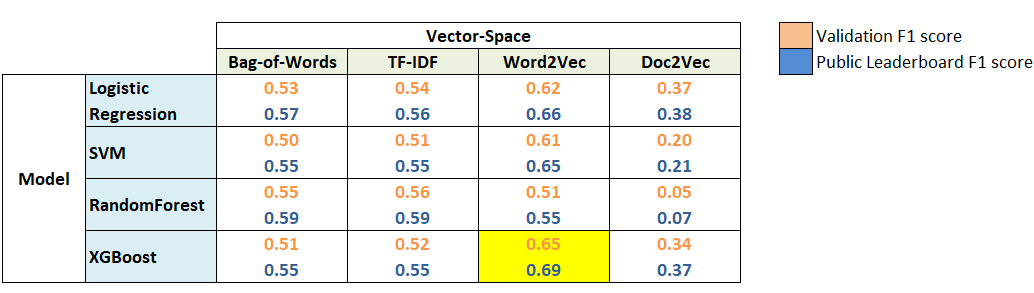

Word2Vec features turned out to be most useful. Whereas XGBoost with Word2Vec features was the best model for this problem. This clearly shows the power of word embeddings in dealing with NLP problems.

WHAT ELSE CAN BE TRIED?

We have covered a lot in this Sentiment Analysis, but still there is plenty of room for other things to try out. Given below is a list of tasks that you can try with this data.

We have built so many models, we can definitely try model ensembling. A simple ensemble of all the submission files (maximum voting) yielded an F1 score of 0.55.

Use Parts-of-Speech tagging to create new features.

Use stemming and/or lemmatization. It might help in getting rid of unnecessary words.

Use bi-grams or tri-grams (tokens of 2 or 3 words respectively) for Bag-of-Words and TF-IDF.

We can give pretrained word-embeddings models a try.
